In [5]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

import requests
import json
import re
from bs4 import BeautifulSoup
import time
import pymongo
import json
import random
import pandas as pd

In [6]:
# 启动 mongodb 服务
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["jdtest"]
mycol = mydb["sites"]

## 规则

In [7]:
# 制冷剂 量化
zlj_role = {'R32':1, 'R41a':0.75, '新冷媒（R410a）':0.75, 'R22':0.5}
# 能效等级 量化
lxdj_role = {'新一级能效':1,'一级能效':0.75,'二级能效':0.5,'三级能效':0.25}
# 匹数 量化
ps_role = {
    '5匹':1,'4匹':0.9,'3匹':0.8,
    '2.5匹':0.7,'2匹':0.6,'1.5匹':0.5,
    '小1.5匹':0.4,'1.5匹':0.3,'大1匹':0.2,
    '1匹':0.1,'小1匹':0.0}
# 变频定频 量化
bpdp_role = {'变频':1,'定频':0}

batch_size = 10

## 提前加载 数据

In [8]:
# res = mycol.findall({'价格':{'$gt':1000,'$lt':10000}}).limit(4000)

def get(data,role,alpha):
    tmp = 0.0
    if data in role:
        tmp = role[data] * alpha
    return tmp

res = mycol.find({'价格':{'$gt':1000,'$lt':10000}},{"_id":0})

data_arr = []
    
index_good = 0
for x in res:
    goods_dict = {}
    tmp_arr = []
    tmp_zr = 0
    tmp_zl = 0
    tmp_zh = 0.0
    try:

        tmp_zr = int(re.findall('(\d+)',x["制热功率(W)"])[0])
        tmp_zl = int(re.findall('(\d+)',x["制冷功率(W)"])[0])

    except:
        pass
    if(tmp_zr+tmp_zl) == 0:
        continue
    tmp_arr.append(0.00014 * tmp_zr)
    tmp_arr.append(0.00014 * tmp_zl)
    if "能效等级" in x:
        tmp_arr.append(get(x["能效等级"],lxdj_role,1))
    else:
        continue
    if "制冷剂" in x:
        tmp_arr.append(get(x["制冷剂"],zlj_role,1))
    else:
        continue
    if "产品匹数" in x:    
        tmp_arr.append(get(x["产品匹数"],ps_role,1))
    else:
        continue
    if "变频/定频" in x:
        tmp_arr.append(get(x["变频/定频"],bpdp_role,1))
    else:
        continue
    goods_dict["param"] = tmp_arr
    goods_dict["price"] = x["价格"]
    data_arr.append(goods_dict)

random.shuffle(data_arr)
data_train = data_arr[0:int(0.7*len(data_arr))]
data_test = data_arr[-int(0.3*len(data_arr)):]
print(len(data_arr),len(data_train),len(data_test))

2689 1882 806


# 批量读取方法

In [9]:
def train_reader():
    res = []
    tmp_i = 0
    for data in data_train:
        tmp_arr = []
        tmp_arr.append(data["param"])
        tmp_arr.append(data["price"])     
        res.append(tmp_arr)
        tmp_i = tmp_i +1
        if tmp_i % batch_size ==0 :
            yield res
            res = []
    random.shuffle(data_train)

def test_reader():
    res = []
    tmp_i = 0
    for data in data_test:
        tmp_arr = []
        tmp_arr.append(data["param"])
        tmp_arr.append(data["price"])     
        res.append(tmp_arr)
        tmp_i = tmp_i +1
        if tmp_i % batch_size ==0 :
            yield res
            res = []
    random.shuffle(data_test)
# data_reader =train_reader()

In [10]:
# for i,data in enumerate(train_reader()):
#     print(i,len(data))

## 定义网络

In [11]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[6], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
y_predict=fluid.layers.fc(input=x,size=1,act=None)

cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.00005)
opts = optimizer.minimize(avg_cost)

test_program = fluid.default_main_program().clone(for_test=True)

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) 

# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名


iter=0;
iters=[]
train_costs=[]

EPOCH_NUM=50
model_save_dir = "./work/fit_a_line.inference.model"

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

##  网络训练

Pass:0, Cost:36828552.00000
Pass:0, Cost:28907348.00000
Pass:0, Cost:37418944.00000
Test:0, Cost:23993490.00000
Pass:1, Cost:35947288.00000
Pass:1, Cost:45687380.00000
Pass:1, Cost:17569244.00000
Test:1, Cost:30242180.00000
Pass:2, Cost:22485808.00000
Pass:2, Cost:19696340.00000
Pass:2, Cost:28630964.00000
Test:2, Cost:27081686.00000
Pass:3, Cost:23750538.00000
Pass:3, Cost:14497293.00000
Pass:3, Cost:27098192.00000
Test:3, Cost:14331035.00000
Pass:4, Cost:19604608.00000
Pass:4, Cost:19006314.00000
Pass:4, Cost:17751396.00000
Test:4, Cost:11061406.00000
Pass:5, Cost:18732396.00000
Pass:5, Cost:19623332.00000
Pass:5, Cost:11050872.00000
Test:5, Cost:14509744.00000
Pass:6, Cost:19893050.00000
Pass:6, Cost:17799824.00000
Pass:6, Cost:12111625.00000
Test:6, Cost:12468415.00000
Pass:7, Cost:15029226.00000
Pass:7, Cost:15133507.00000
Pass:7, Cost:11479814.00000
Test:7, Cost:9078194.00000
Pass:8, Cost:19270664.00000
Pass:8, Cost:12030350.00000
Pass:8, Cost:13332832.00000
Test:8, Cost:6586239.

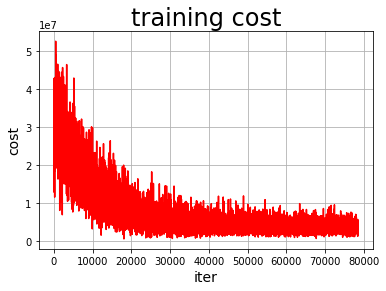

In [18]:


for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 70 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+batch_size
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    print()
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)

## 现实数据预测

In [36]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

infer_results=[]
groud_truths=[]
key_dict = {"预测价格":[],"当前价格":[],"物超所值":[],"制热功率":[],"制冷功率":[],"能效等级":[],"制冷剂":[],"产品匹数":[],"变频/定频":[]}
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
#     infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
#                           batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(test_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    print(test_x[0])
    test_x[0] = [0.2,0.1512,0.25,1.,0.3,1.]
    test_y[0] = 3599.00
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
#     print("空调型号是否入手：")
    
#     print(results[0])
    for i in range(10):
#         print('预测:',results[0][i][0],'市价:',test_y[i],'\t 入手:',(results[0][i][0]-test_y[i])>0)
        key_dict["预测价格"].append(int(results[0][i][0]))
        key_dict["当前价格"].append(int(test_y[i]))
        key_dict["物超所值"].append((results[0][i][0]-test_y[i])>0)
        key_dict["制热功率"].append(test_x[i][0])
        key_dict["制冷功率"].append(test_x[i][1])
        key_dict["能效等级"].append(test_x[i][2])
        key_dict["制冷剂"].append(test_x[i][3])
        key_dict["产品匹数"].append(test_x[i][4])
        key_dict["变频/定频"].append(test_x[i][5])
x = pd.DataFrame(key_dict)
x
        
        
#     for idx, val in enumerate(results[0]):
#         print("%d: %.2f" % (idx, val))
#         infer_results.append(val)
#     print("ground truth:")
#     for idx, val in enumerate(test_y):
#         print("%d: %.2f" % (idx, val))
#         groud_truths.append(val)

[0.3052 0.2212 0.25   1.     0.6    1.    ]


,预测价格,当前价格,物超所值,制热功率,制冷功率,能效等级,制冷剂,产品匹数,变频/定频
0,4803,3599,True,0.20000,0.15120,0.25,1.0,0.3,1.0
1,4790,3199,True,0.18480,0.14000,0.25,1.0,0.3,1.0
2,5050,3332,True,0.20300,0.08400,0.75,1.0,0.1,1.0
3,4656,3378,True,0.14490,0.11480,0.25,1.0,0.2,1.0
4,4228,5399,False,0.32200,0.32536,0.25,1.0,0.8,0.0
5,5514,5999,False,0.43540,0.32900,0.25,1.0,0.8,1.0
6,5515,7249,False,0.43400,0.33320,0.25,1.0,0.8,1.0
7,5732,6799,False,0.06482,0.07924,1.00,1.0,0.6,1.0
8,6203,9999,False,0.40600,0.29400,1.00,1.0,0.8,1.0
9,6203,7799,False,0.40600,0.29400,1.00,1.0,0.8,1.0
